# DynapSE Brian2 VS DynapSEtorch simulation

In this example we will compare the simulation obtained from the DynapSE simulator in Brian2 with DynapSEtorch. First we need to download the dynapse-simulator repository.

In [1]:
%%bash
pip install git+https://github.com/ferqui/DynapSEtorch.git
git -C dynapse-simulator pull || git clone https://code.ini.uzh.ch/ncs/libs/dynapse-simulator.git
cd dynapse-simulator
git checkout mismatch

fatal: cannot change to 'dynapse-simulator': No such file or directory
Cloning into 'dynapse-simulator'...
Switched to a new branch 'mismatch'


Branch 'mismatch' set up to track remote branch 'mismatch' from 'origin'.


In [2]:
import os
import sys

sys.path.insert(0, os.path.expanduser("./dynapse-simulator"))

import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Brian2 DynapSE libraries
from brian2 import *
from DynapSE import DynapSE
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# DynapSEtorch model
from dynapsetorch.model import AdexLIF

# Display plots inside Jupyter cell
%matplotlib inline
# Set the dots-per-inch (resolution) of the images
mpl.rcParams["figure.dpi"] = 90

First we define the simulation timestep ($100 \mu s$) for Brian2 and DynapSEtorch.

In [3]:
# C++ code generation for faster spiking network simulation
set_device("cpp_standalone")
# Ignore Brian2 base warnings
BrianLogger.suppress_name("base")
# The clock of Brian2 simulation for numerically solve ODEs
torchtimestep = 100 * 1e-6  # 100us
defaultclock.dt = torchtimestep * second

## Input spike pattern

In order to test the implementation of DynapSEtorch with Brian2 simulation, we are going to create a random input pattern that follows a poisson distribution. Since the synapse type can be either `AMPA`, `NMDA`, `GABA_A` and `GABA_B`, we are going to create four different input spike trains.

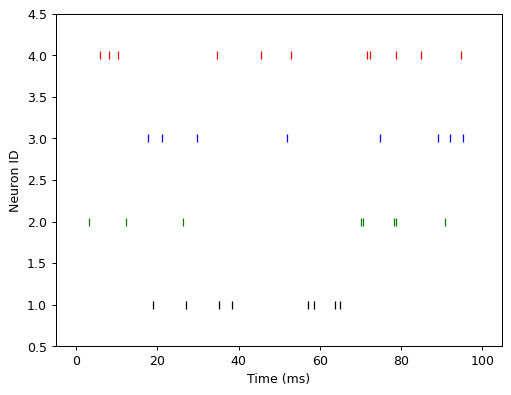

In [4]:
# Parameters
pulse_start = 0  # second - Start time of input (Default: 0)
pulse_stop = 1  # second - Stop time of input (Default: 1)
inp_duration = 0.1  # second - Simulation duration (Default: 100ms)
rate = 80  # Hz - Spiking rate (Default: 100 Hz)
##################

prob = rate * torchtimestep
mask = torch.rand(4, int(inp_duration / torchtimestep))
spikes = torch.zeros(4, int(inp_duration / torchtimestep))
spikes[mask < prob] = 1.0
spikes[: pulse_start * int(1 / torchtimestep)] = 0
spikes[pulse_stop * int(1 / torchtimestep) :] = 0

timeduration = np.arange(int(inp_duration / torchtimestep)) * torchtimestep * 1e3
plt.plot(timeduration, spikes[0], "k|")
plt.plot(timeduration, spikes[1] * 2, "g|")
plt.plot(timeduration, spikes[2] * 3, "b|")
plt.plot(timeduration, spikes[3] * 4, "r|")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron ID")
plt.ylim(0.5, 4.5)
plt.show()

Now that we have created the input spike patter for all the synapses, we need to tell Brian2 to use those spikes. To do that, we have to created 4 SpikegeneratorGroup (one per synapse type), with the ID of the spike source and the spike timing.

In [5]:
# Reinitialize the device
device.reinit()
device.activate()
defaultclock.dt = torchtimestep * second

spike_timing = np.where(spikes[0] == 1)[0] * torchtimestep * second  # Timing of spikes
neuron_indices = np.zeros(len(spike_timing))  # ID of spike sources
nmda_spike_generator = SpikeGeneratorGroup(
    1, indices=neuron_indices, times=spike_timing, name="NMDASpikeGenerator"
)

spike_timing = np.where(spikes[1] == 1)[0] * torchtimestep * second  # Timing of spikes
neuron_indices = np.zeros(len(spike_timing))  # ID of spike sources
ampa_spike_generator = SpikeGeneratorGroup(
    1, indices=neuron_indices, times=spike_timing, name="AMPASpikeGenerator"
)

spike_timing = np.where(spikes[2] == 1)[0] * torchtimestep * second  # Timing of spikes
neuron_indices = np.zeros(len(spike_timing))  # ID of spike sources
gabaa_spike_generator = SpikeGeneratorGroup(
    1, indices=neuron_indices, times=spike_timing, name="GABAaSpikeGenerator"
)

spike_timing = np.where(spikes[3] == 1)[0] * torchtimestep * second  # Timing of spikes
neuron_indices = np.zeros(len(spike_timing))  # ID of spike sources
gabab_spike_generator = SpikeGeneratorGroup(
    1, indices=neuron_indices, times=spike_timing, name="GABAbSpikeGenerator"
)

## Creating networks

The next step will be to create the Brian2 and DynapSEtorch network. 
### Brian2

In [6]:
network = Network()  # Instantiate a Brian2 Network
chip = DynapSE(
    network
)  # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

input = spikes.unsqueeze(2)

nmda, ampa, gaba_a, gaba_b = 10, 5, 1, 2

### DynapSEtorch

to create the DynapSEtorch network, we have to create a group of neurons of type AdexLIF, indicating the number of neurons that it would have. Also we have to indicate the timestep of the simulation, as we did with Brian2 and the weights of each synapse type.

In [7]:
model = AdexLIF(1)
model.dt = torchtimestep
model.weight_nmda.data = torch.ones(1, 1) * nmda
model.weight_ampa.data = torch.ones(1, 1) * ampa
model.weight_gaba_a.data = torch.ones(1, 1) * gaba_a
model.weight_gaba_b.data = torch.ones(1, 1) * gaba_b

## We don't want to add mismatch
model.Inmda_w0 = torch.zeros_like(model.Inmda_w0) + 100 * 1e-12
model.Iampa_w0 = torch.zeros_like(model.Inmda_w0) + 100 * 1e-12
model.Igaba_a_w0 = torch.zeros_like(model.Inmda_w0) + 100 * 1e-12
model.Igaba_b_w0 = torch.zeros_like(model.Inmda_w0) + 100 * 1e-12

Once define the network for DynapSEtorch and Brian2, we can connect the spikes generator created previously with the Brian2 model.

In [8]:
DPI_neuron = chip.get_neurons(1, "Core_1")  # Allocate single DPI neuron from Core
DPI_NMDA_synapse = chip.add_connection(
    nmda_spike_generator, DPI_neuron, synapse_type="NMDA"
)  # Define a fast excitatory synapse1
DPI_AMPA_synapse = chip.add_connection(
    ampa_spike_generator, DPI_neuron, synapse_type="AMPA"
)  # Define a fast excitatory synapse
DPI_GABAa_synapse = chip.add_connection(
    gabaa_spike_generator, DPI_neuron, synapse_type="GABA_A"
)  # Define a fast excitatory synapse
DPI_GABAb_synapse = chip.add_connection(
    gabab_spike_generator, DPI_neuron, synapse_type="GABA_B"
)  # Define a fast excitatory synapse


DPI_neuron.set_states({"Isoma_pfb_th": 1000 * pA, "Isoma_th": 2000 * pA})
# In Brian2 creating Synapses instance does not connect two endpoints, it only specifies synaptic dynamics
# Let's connect two endpoints and set an initial weight of 300.

chip.connect(DPI_NMDA_synapse, True)
DPI_NMDA_synapse.weight = nmda

chip.connect(DPI_AMPA_synapse, True)
DPI_AMPA_synapse.weight = ampa

chip.connect(DPI_GABAa_synapse, True)
DPI_GABAa_synapse.weight = gaba_a

chip.connect(DPI_GABAb_synapse, True)
DPI_GABAb_synapse.weight = gaba_b

1 neurons are allocated from Core_1.


The next step would be to add monitors to record the internal states of the neurons in Brian2 and add it to the network.

In [9]:
# Monitors
mon_neuron_input = SpikeMonitor(nmda_spike_generator, name="mon_neuron_input")
mon_synapse_nmda = StateMonitor(DPI_NMDA_synapse, "Inmda", record=[0])
mon_synapse_ampa = StateMonitor(DPI_AMPA_synapse, "Iampa", record=[0])
mon_synapse_gaba_a = StateMonitor(DPI_GABAa_synapse, "Igaba_a", record=[0])
mon_synapse_gaba_b = StateMonitor(DPI_GABAb_synapse, "Igaba_b", record=[0])
mon_neuron_state = StateMonitor(DPI_neuron, "Isoma_mem", record=True)
mon_ahp_state = StateMonitor(DPI_neuron, "Isoma_ahp", record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name="mon_neuron_output")

# Add every instance we created to Brian network, so it will include them in the simulation
network.add(
    [
        nmda_spike_generator,
        ampa_spike_generator,
        gabaa_spike_generator,
        gabab_spike_generator,
        DPI_neuron,
        DPI_NMDA_synapse,
        DPI_AMPA_synapse,
        DPI_GABAa_synapse,
        DPI_GABAb_synapse,
        mon_ahp_state,
        mon_neuron_input,
        mon_synapse_nmda,
        mon_synapse_ampa,
        mon_synapse_gaba_a,
        mon_synapse_gaba_b,
        mon_neuron_output,
        mon_neuron_state,
    ]
)

WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]
WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]
WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]
WARNING    Cannot check w

## Launch simulation

### Brian2
First we are going to launch the Brian2 simulation and the record the Elapsed time need to finish

In [10]:
# Simulation
start = time.time()
network.run(inp_duration * 1000 * ms)
end = time.time()
brian2_duration = end - start
print("Elapsed time: " + str(brian2_duration))

Elapsed time: 11.160083055496216


In [11]:
start = time.time()
output = []
output_nmda = []
output_ampa = []
output_gaba_a = []
output_gaba_b = []
output_Isoma = []
model.state = model.init_state(input[0][0])
with torch.no_grad():
    for t in range(input.shape[1]):
        output_nmda.append(model.state.Inmda.clone())
        output_ampa.append(model.state.Iampa.clone())
        output_gaba_a.append(model.state.Igaba_a.clone())
        output_gaba_b.append(model.state.Igaba_b.clone())
        output_Isoma.append(model.state.Isoma_mem.clone())
        S = model(input[0][t], input[1][t], input[2][t], input[3][t])
        output.append(S)

output = torch.stack(output, dim=1)
output_nmda = torch.stack(output_nmda, dim=1)
output_ampa = torch.stack(output_ampa, dim=1)
output_gaba_a = torch.stack(output_gaba_a, dim=1)
output_gaba_b = torch.stack(output_gaba_b, dim=1)
output_Isoma = torch.stack(output_Isoma, dim=1)
end = time.time()
dynapsetorch_duration = end - start
print("Elapsed time: " + str(dynapsetorch_duration))

Elapsed time: 1.4313929080963135


In [12]:
print("Brian2 simulation duration: ", brian2_duration)
print("DynapSEtorch simulation duration: ", dynapsetorch_duration)

Brian2 simulation duration:  11.160083055496216
DynapSEtorch simulation duration:  1.4313929080963135


## Visualize the results

Finally we can visualize the results obtained on both simulations.

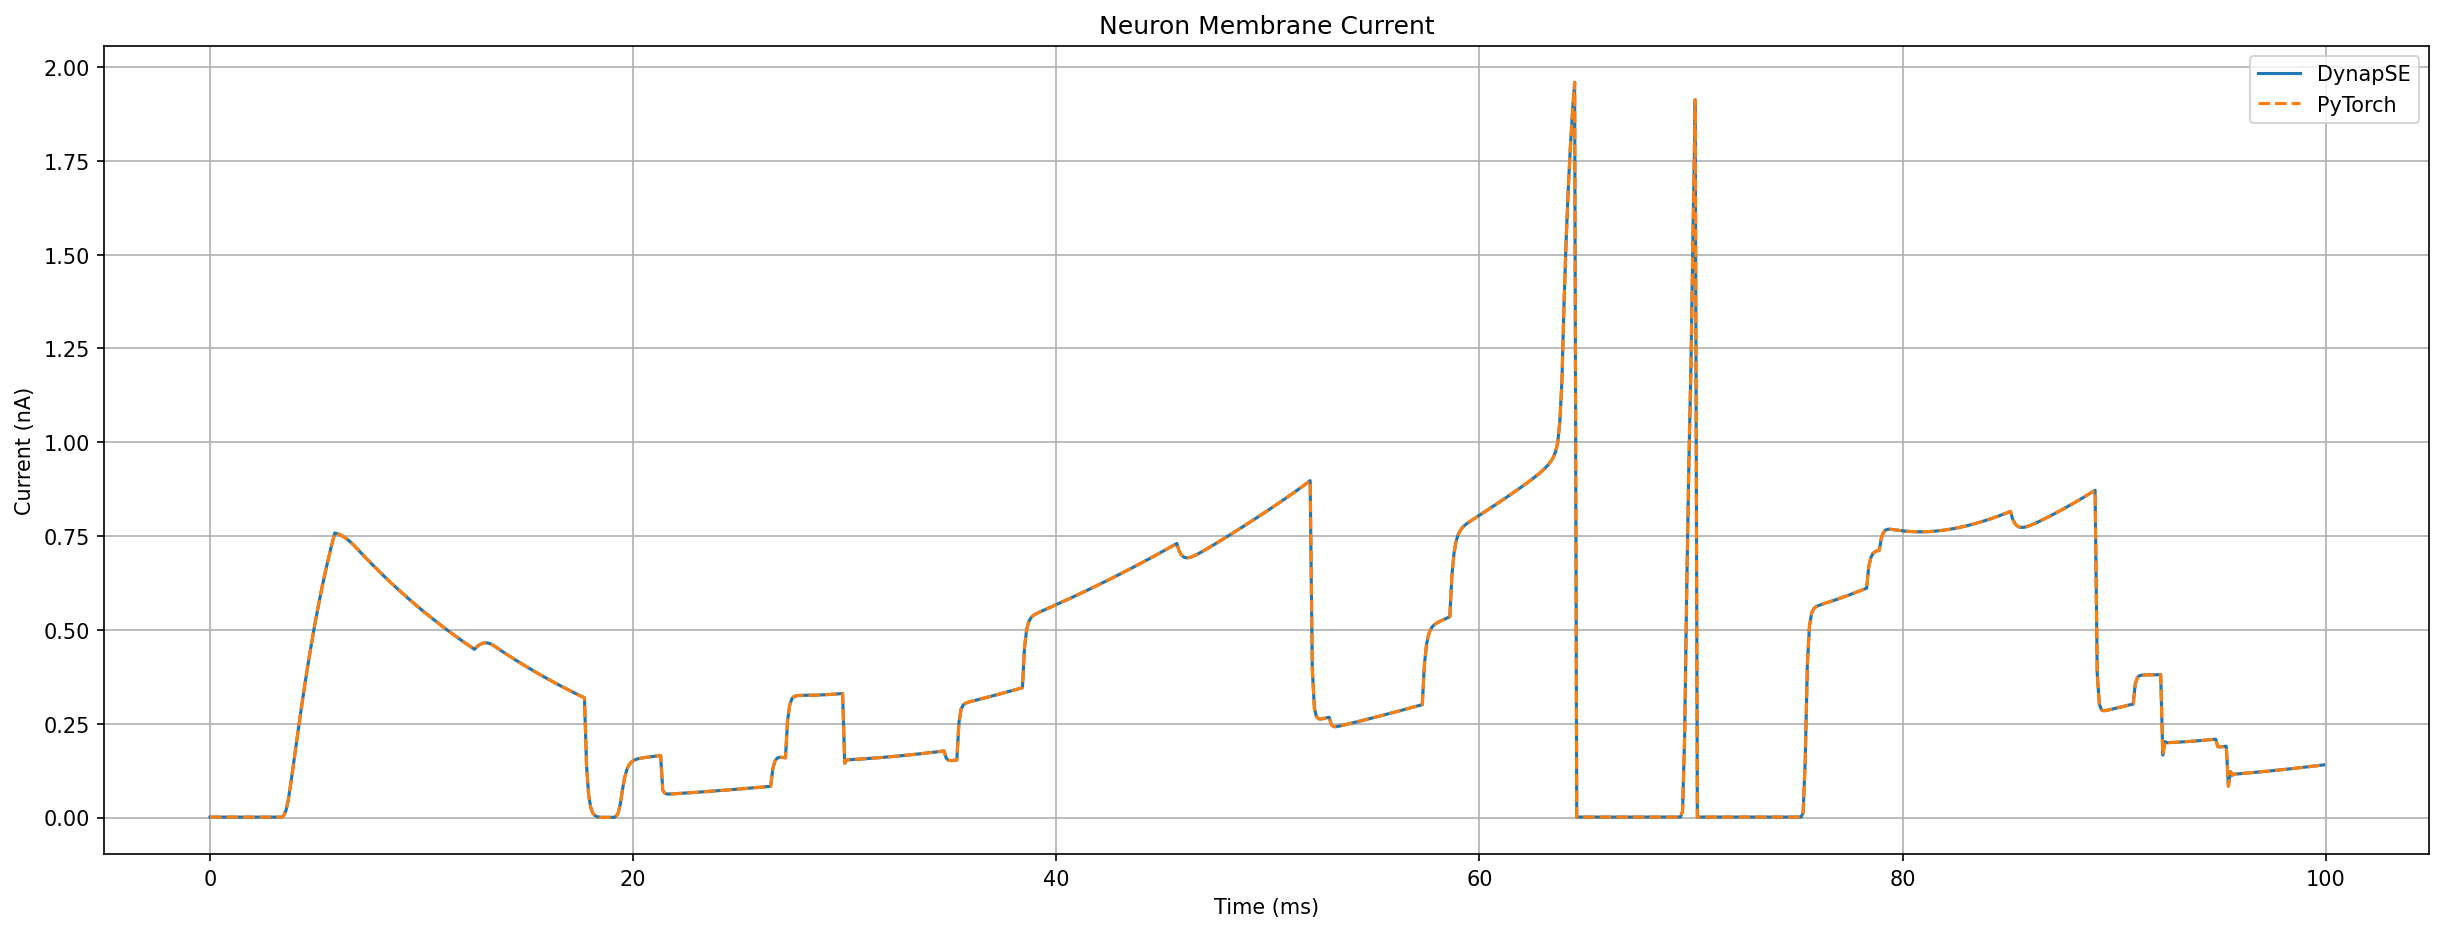

In [13]:
plt.figure(figsize=(20, 7), dpi=150)
plt.subplots_adjust(hspace=0.5)

plt.subplot(111)
Isoma_mem = mon_neuron_state.Isoma_mem[0]
plt.plot(mon_neuron_state.t / ms, Isoma_mem / namp)
plt.plot(mon_neuron_state.t / ms, output_Isoma[0].detach() * 1e9, "--")

plt.title("Neuron Membrane Current")
plt.ylabel("Current (nA)")
plt.legend(["DynapSE", "PyTorch"])
plt.xlabel("Time (ms)")
plt.grid(True)
plt.show()

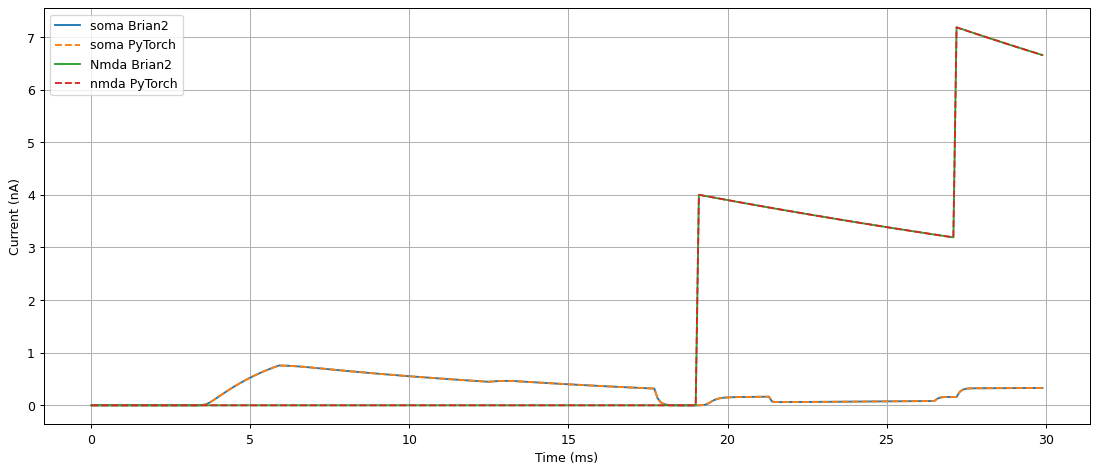

In [14]:
tstart = 0  # ms
tend = 30  # ms
##################

plt.figure(figsize=(15, 6))
s = int(1 * ms / defaultclock.dt)
plt.plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    Isoma_mem[tstart * s : tend * s] / namp,
)
plt.plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    output_Isoma[0][tstart * s : tend * s].detach() * 1e9,
    "--",
)
plt.plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    mon_synapse_nmda.Inmda[0][tstart * s : tend * s] / namp,
    linewidth=1.5,
)
plt.plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    output_nmda[0][tstart * s : tend * s] * 1e9,
    "--",
    linewidth=1.5,
)
plt.ylabel("Current (nA)")
plt.xlabel("Time (ms)")
plt.legend(["soma Brian2", "soma PyTorch", "Nmda Brian2", "nmda PyTorch"])
plt.grid(True)

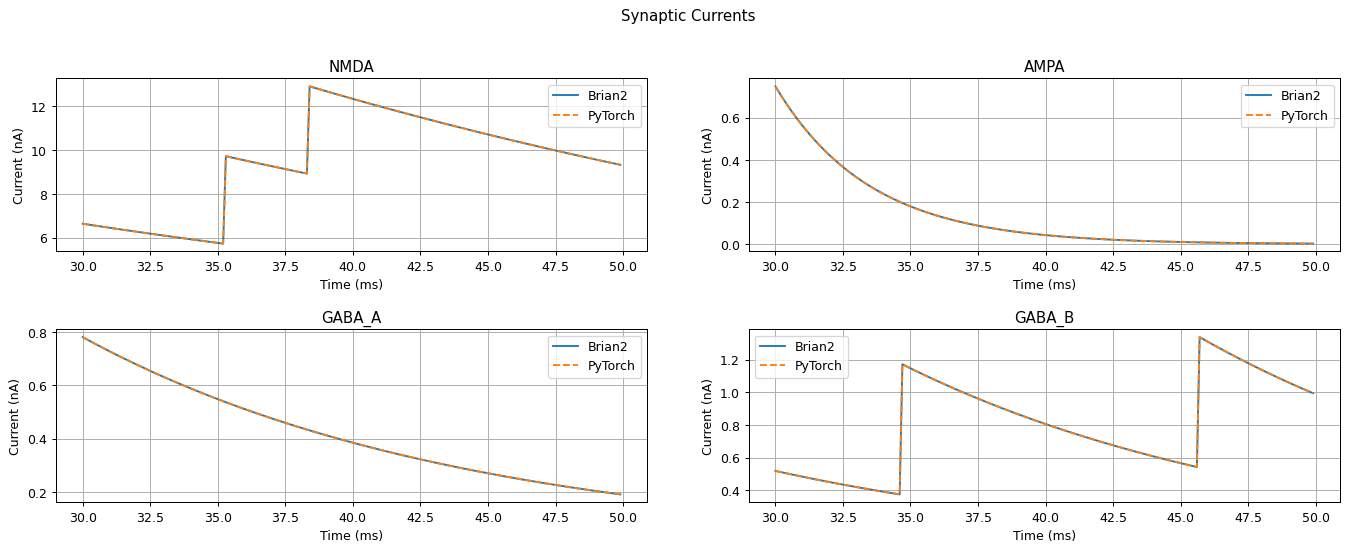

In [15]:
# Parameters
tstart = 30  # ms
tend = 50  # ms
##################

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
fig.tight_layout(w_pad=5, h_pad=5)
s = int(1 * ms / defaultclock.dt)

axs[0, 0].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    mon_synapse_nmda.Inmda[0][tstart * s : tend * s] / namp,
    linewidth=1.5,
)
axs[0, 0].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    output_nmda[0][tstart * s : tend * s] * 1e9,
    "--",
    linewidth=1.5,
)
axs[0, 0].legend(["Brian2", "PyTorch"])
axs[0, 0].title.set_text("NMDA")
axs[0, 0].set_ylabel("Current (nA)")
axs[0, 0].set_xlabel("Time (ms)")
axs[0, 0].grid(True)

axs[0, 1].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    mon_synapse_ampa.Iampa[0][tstart * s : tend * s] / namp,
    linewidth=1.5,
)
axs[0, 1].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    output_ampa[0][tstart * s : tend * s] * 1e9,
    "--",
    linewidth=1.5,
)
axs[0, 1].legend(["Brian2", "PyTorch"])
axs[0, 1].title.set_text("AMPA")
axs[0, 1].set_ylabel("Current (nA)")
axs[0, 1].set_xlabel("Time (ms)")
axs[0, 1].grid(True)

axs[1, 0].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    mon_synapse_gaba_a.Igaba_a[0][tstart * s : tend * s] / namp,
    linewidth=1.5,
)
axs[1, 0].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    output_gaba_a[0][tstart * s : tend * s] * 1e9,
    "--",
    linewidth=1.5,
)
axs[1, 0].legend(["Brian2", "PyTorch"])
axs[1, 0].title.set_text("GABA_A")
axs[1, 0].set_ylabel("Current (nA)")
axs[1, 0].set_xlabel("Time (ms)")
axs[1, 0].grid(True)

axs[1, 1].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    mon_synapse_gaba_b.Igaba_b[0][tstart * s : tend * s] / namp,
    linewidth=1.5,
)
axs[1, 1].plot(
    mon_neuron_state.t[tstart * s : tend * s] / ms,
    output_gaba_b[0][tstart * s : tend * s] * 1e9,
    "--",
    linewidth=1.5,
)
axs[1, 1].legend(["Brian2", "PyTorch"])
axs[1, 1].title.set_text("GABA_B")
axs[1, 1].set_ylabel("Current (nA)")
axs[1, 1].set_xlabel("Time (ms)")
axs[1, 1].grid(True)

fig.suptitle("Synaptic Currents")
fig.subplots_adjust(top=0.85)

# display subplots
plt.show()